In [1]:
#Importa módulos necesarios
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import derivative
import matplotlib.animation as animation
from google.colab import drive
import os
from IPython.display import HTML
from base64 import b64encode

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/espec_practica/' #Ruta donde trabajar
os.chdir(path);

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

plt.rcParams['lines.markersize'] = 14
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['axes.formatter.use_mathtext'] = True

# Lectura de datos

In [4]:
#Abre el fichero para extraer los datos
f = open('data', 'rb')

#Dimensiones
nt = struct.unpack('i', f.read(4))[0] #Temporal
nl = struct.unpack('i', f.read(4))[0] #Espacial

#Longitud de onda
wave = np.array(struct.unpack('d'*nl, f.read(8*nl))) #[AA]

#Disco
Stokes_0 = np.array(struct.unpack('d'*nl*4, f.read(8*nl*4))).reshape(4, nl)

#Datos
Stokes = np.array(struct.unpack('d'*nl*nt*4, f.read(8*nl*nt*4))).reshape((nt, 4, nl))

#Cierra el fichero
f.close()

# Funciones para plotear y animar

In [5]:
def plot(nrows, ncols, x, y, fig, wspace, mrk, xlabels, ylabels, name):
    n = nrows * ncols

    if n > 1:
        #Crea figura y subplots
        f, ax = plt.subplots(nrows, ncols, figsize=fig)
        ax = ax.flatten()
        for i in range(n):
            ax[i].plot(x, y[i], mrk, color='mediumpurple', lw = 2)
            ax[i].set_xlabel(xlabels[i])
            ax[i].set_ylabel(ylabels[i])
    else:
        f, ax = plt.subplots(nrows, ncols, figsize=fig)
        ax.plot(x, y, mrk, color='mediumpurple', lw=2)
        ax.set_xlabel(xlabels)
        ax.set_ylabel(ylabels)

    plt.subplots_adjust(wspace=wspace, hspace=0.22)

    plt.savefig(name + '.png', format = 'png')
    plt.show()

    return

In [6]:
def anima(dt_show, nt, x, y, ylim, off, xlabels, ylabels, title, name):
    #Inicializa el tiempo
    t = 0

    #Crear figura y subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    #Inicializa las líneas para los subplots
    lines = []

    for i, ax in enumerate(axs.flat):
        line, = ax.plot([], [], color='mediumpurple', lw=2)
        ax.set_xlim(x.min(), x.max())
        if i == 0:  #Primer subplot
            ax.set_ylim(ylim[0] * y[:, i, :].min() + off[0], ylim[1] * y[:, i, :].max() + off[1])
        else:
            ax.set_ylim(ylim[0] * y[:, i, :].min(), ylim[1] * y[:, i, :].max())

        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
        lines.append(line)

    #Animación
    def animate(frame):
        nonlocal t
        t = frame  # Actualiza el tiempo actual
        for i, line in enumerate(lines):
            line.set_data(x, y[t, i, :])  # Actualiza los datos
        fig.suptitle(title + r' ($t$ = %.2f)' % (t * dt_show))
        return lines

    #Configura la animación
    ani = animation.FuncAnimation(fig, animate, frames=nt, interval=150, blit=True, repeat=True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.22, top=0.93)

    #Guardar animación
    ani.save(name + '.mp4', writer='ffmpeg', fps=7)

    plt.close(fig)

    return

# Parte 1

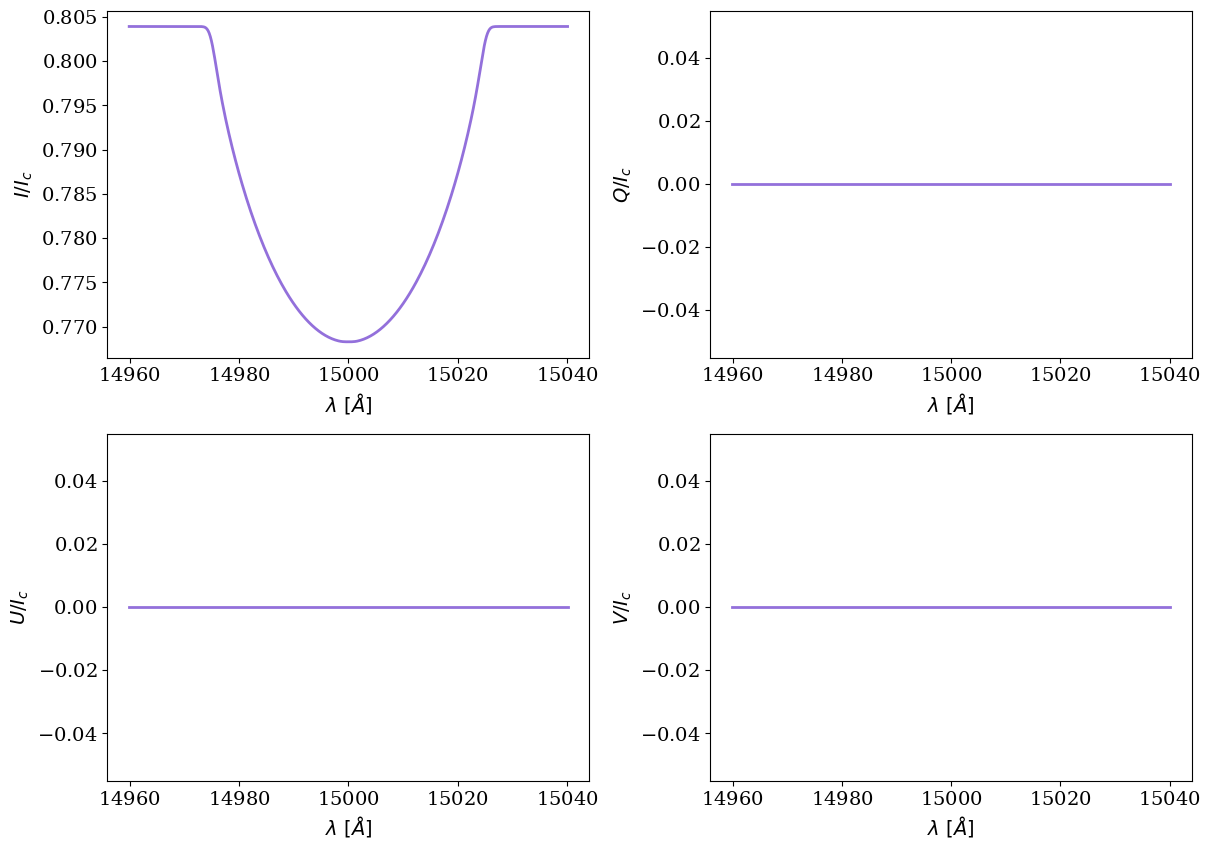

In [7]:
#Plot de parámetros de Stokes del espectro no perturbado
xlabels = [r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$']
ylabels = [r'$I/I_c$', r'$Q/I_c$', r'$U/I_c$', r'$V/I_c$']

plot(nrows=2, ncols=2, x=wave, y=Stokes_0, fig=(14, 10), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='Stokes_0');

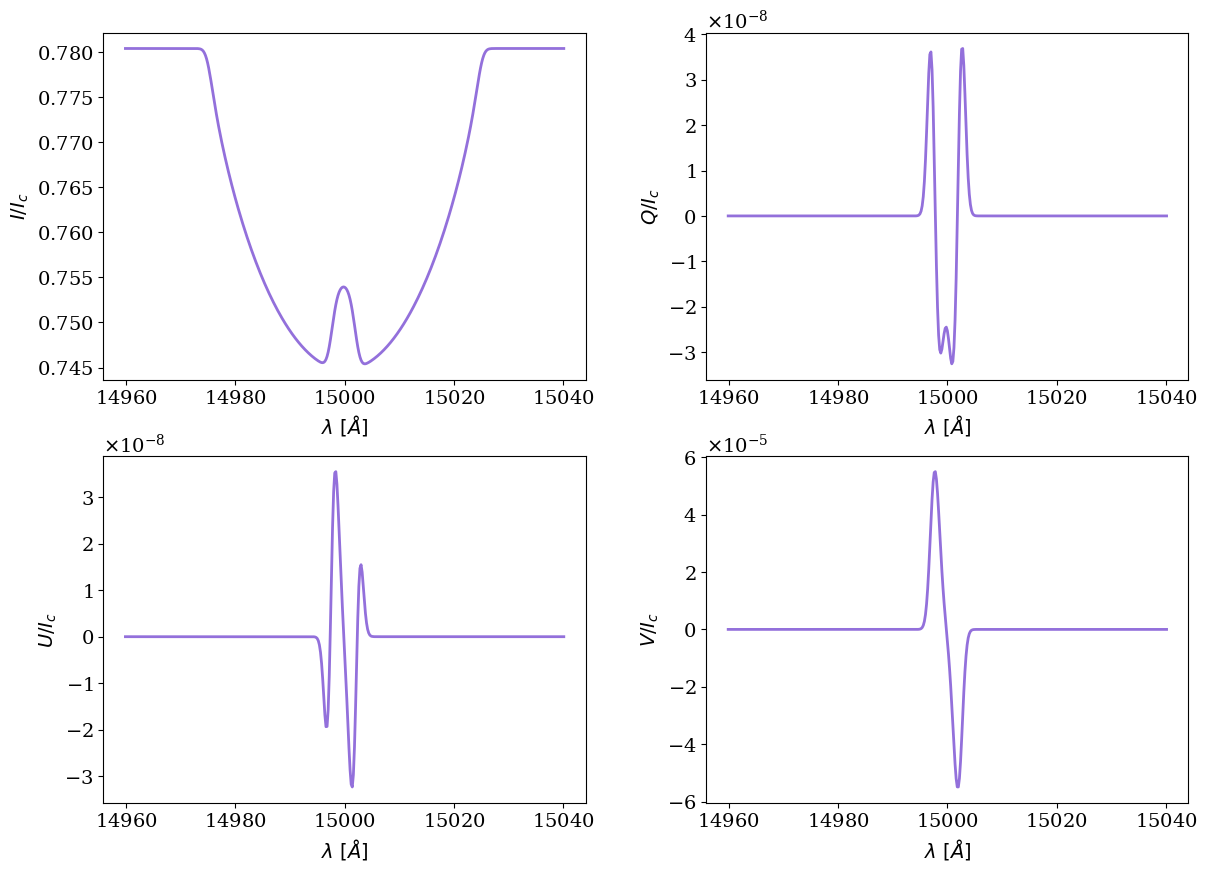

In [8]:
#Plot de parámetros de Stokes del espectro observado a t = 21
plot(nrows=2, ncols=2, x=wave, y=Stokes[21], fig=(14, 10), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='Stokes');

In [9]:
#Animación de parámetros de Stokes del espectro observado
anima(dt_show=1, nt=nt, x=wave, y=Stokes, ylim=(0.99, 1.05), off=(0, 0), xlabels=xlabels, ylabels=ylabels, \
            title='Evolución de los parámetros de Stokes del espectro observado', name='Stokes')

In [10]:
#Mostrar animación
mp4 = open('Stokes.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 height=650 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [11]:
#Calcula los parámetros de Stokes del residuo
R = Stokes - Stokes_0 #Resta de datos perturbados y sin perturbar

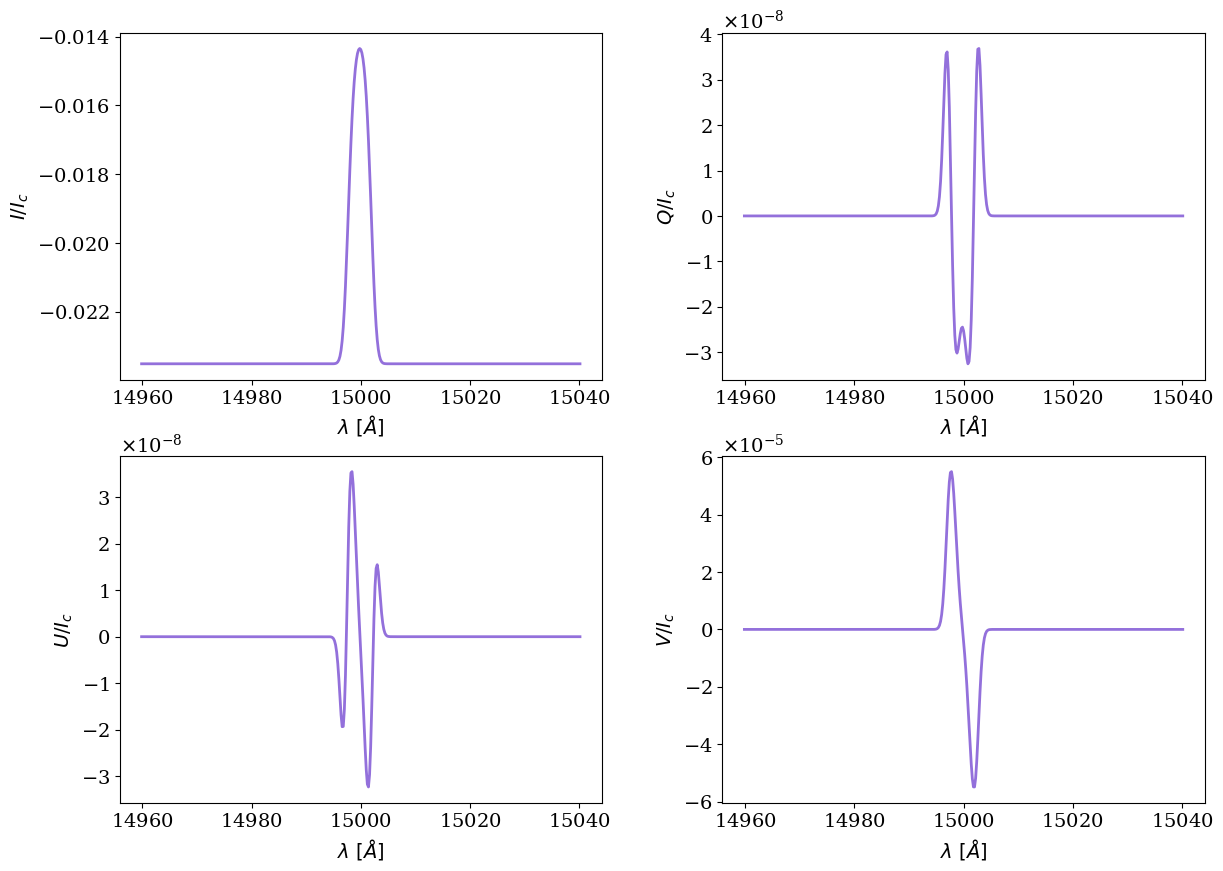

In [12]:
#Plot de parámetros de Stokes del residuo a t = 21
plot(nrows=2, ncols=2, x=wave, y=R[21], fig=(14, 10), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='res');

In [13]:
#Animación de parámetros de Stokes del residuo
anima(dt_show=1, nt=nt, x=wave, y=R, ylim=(1.1, 1.05), off=(0, 0.002), xlabels=xlabels, ylabels=ylabels, \
               title='Evolución de los parámetros de Stokes del residuo', name = 'Stokes_res')

In [14]:
#Mostrar animación
mp4 = open('Stokes_res.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 height=650 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Parte 2

In [15]:
#Índices del pico del residuo en el tiempo
mancha = np.argmax(R[:, 0, :], axis=1)

#Índices del pico del residuo en el tiempo con valores distintos de 0 (correspondientes a cara visible)
index = np.where(mancha != 0)[0]

In [16]:
#Longitud de onda central de la mancha (en reposo)
lambda_0 = 15000 #[AA]

#Velocidad de la luz
c = 3e5 #[km/s]

#Desplazamiento Doppler de la mancha en el tiempo
dlambda = wave[mancha][index] - lambda_0 #[AA]

#Velocidad en LOS de la mancha en el tiempo
vLOS = c * dlambda/lambda_0 #[km/s]

In [17]:
#Periodo de rotación de la estrella
T = nt - 1

#Array de tiempos durante la rotación
t = np.linspace(0, T, nt)

#Fase de rotación completa de la mancha
fase = t/T

#Fase de la mancha para la cara visible
fase = fase[index]

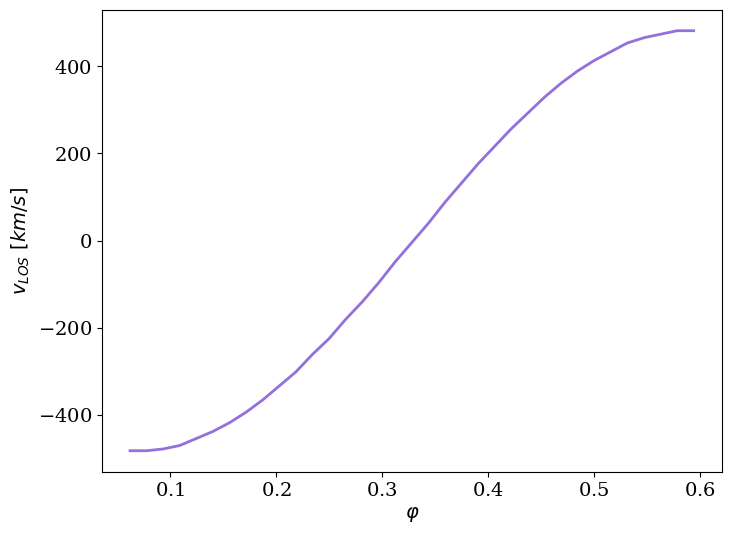

In [18]:
#Plot de velocidad de la mancha frente a su fase
xlabel = r'$\varphi$'
ylabel = r'$v_{LOS} \ [km/s]$'

plot(nrows=1, ncols=1, x=fase, y=vLOS, fig=(8, 6), wspace=0.25, mrk='-', xlabels=xlabel, ylabels=ylabel, name='fase_vLOS')

In [19]:
#Fase de la mancha cuando está en el meridiano central
fase_0 = fase[17]
print(f'La fase de la mancha cuando está en el meridiano central es de {2*np.pi*fase_0:.2f} [rad]')

#Expresión analítica de la velocidad en la LOS
def vLOS_modelo(fase, latitud):
  #Velocidad de rotación de la estrella
  v_rot = 500 #[km/s]

  #Ángulo del eje de rotación con respecto a la LOS
  i = np.pi/2 #[rad]

  vLOS = v_rot * np.cos(latitud) * np.sin(i) * np.sin(2*np.pi*(fase - fase_0)) #[km/s]
  return vLOS

La fase de la mancha cuando está en el meridiano central es de 2.06 [rad]


In [20]:
#Ajuste a la expresión analítica de la velocidad en la LOS
vLOS_coeff,_ = curve_fit(vLOS_modelo, fase, vLOS, p0 = np.pi/2)

#Latitud de la mancha
latitud = vLOS_coeff[0] * 180/np.pi #[grados]
print(f'La mancha se encuentra a una latitud de {latitud:.2f}º')

#Velocidad teórica en la LOS
vLOS_analitic = vLOS_modelo(fase, vLOS_coeff) #[km/s]

La mancha se encuentra a una latitud de 18.49º


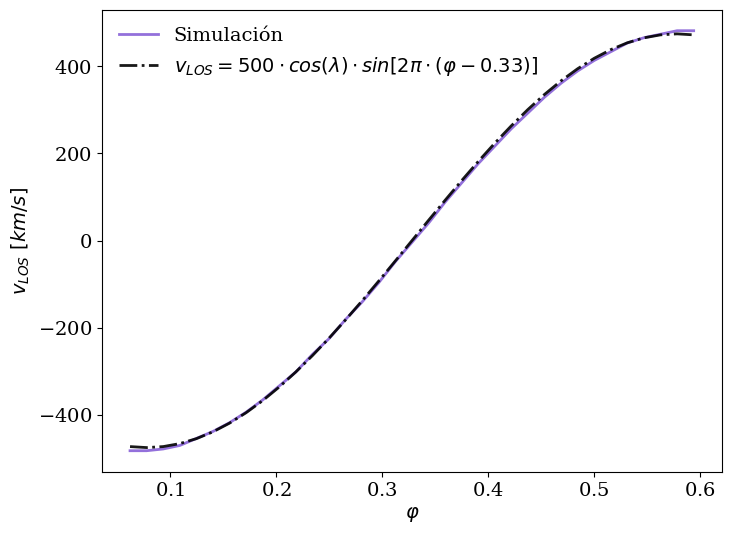

In [21]:
#Plot de velocidad de la mancha frente a la fase junto con el ajuste a la expresión analítica
f = plt.figure(figsize=(8, 6))
plt.plot(fase, vLOS, '-', color='mediumpurple', lw=2, label = 'Simulación')
plt.plot(fase, vLOS_analitic, '-.', color = 'black', lw=2, alpha = 0.9, label = r'$v_{LOS} = 500\cdot cos(\lambda) \cdot sin[2\pi\cdot (\varphi - 0.33)]$')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc = 'upper left', frameon = False)

plt.savefig('vLOS_ajuste' + '.png', format = 'png')
plt.show()

In [22]:
#Velocidad de la mancha para posiciones centrales (cercanas al meridiano central)
vLOS_central = vLOS[(fase > 0.25) & (fase < 0.45)]

#Fase de posiciones centrales
fase_central = fase[(fase > 0.25) & (fase < 0.45)]

In [23]:
#Pendiente y ordenada en el origen del ajuste a una recta de las velocidades de la mancha y fases para posiciones centrales
m, b = np.polyfit(fase_central, vLOS_central, 1)
print(f'La pendiente de la recta es m = {m:.2f} km/s')
print(f'La ordena en el origen de la recta es b = {b:.2f} km/s')

#Velocidad de la mancha mediante ajuste a una recta (solo para posiciones centrales)
vLOS_recta_central = m * fase_central + b #[km/s]

#Velocidad de la mancha mediante ajuste a una recta (incluyendo limbo)
vLOS_recta = m * fase + b #[km/s]

La pendiente de la recta es m = 2808.97 km/s
La ordena en el origen de la recta es b = -926.35 km/s


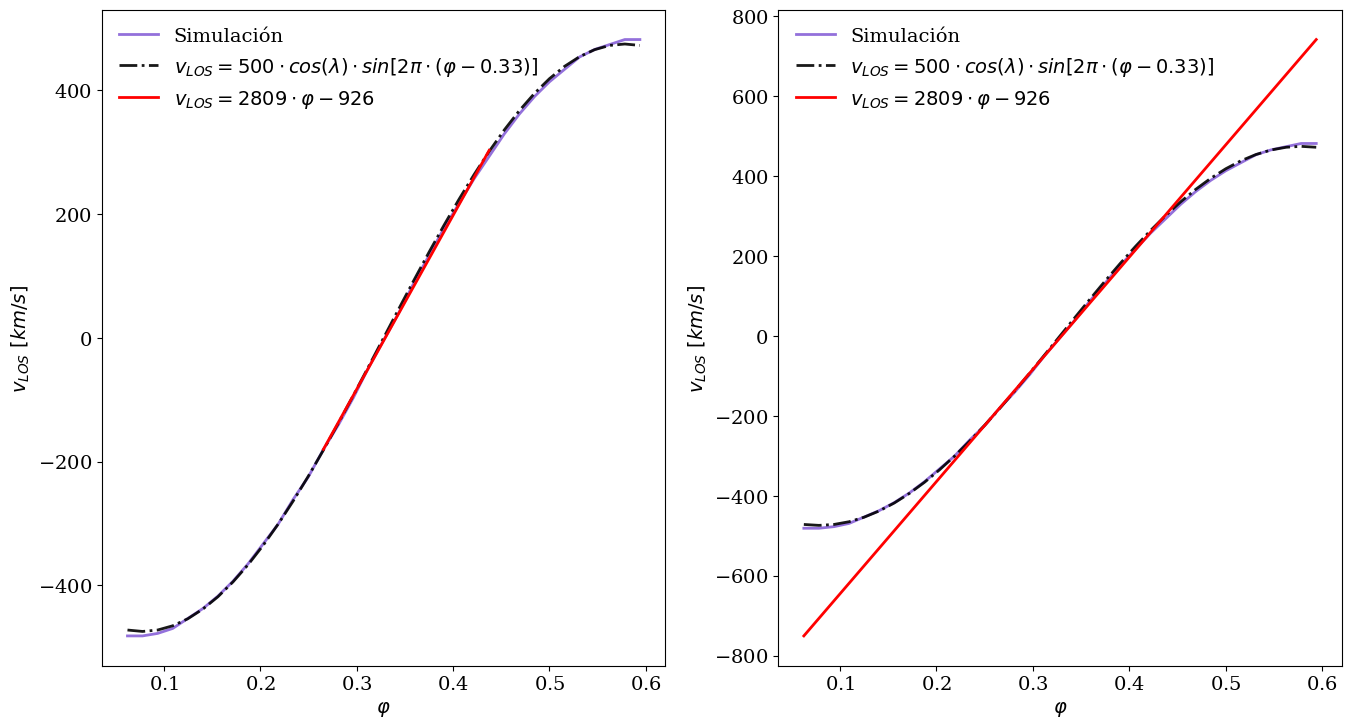

In [24]:
#Plot de velocidad de la mancha frente a la fase junto con los ajustes
f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
ax[0].plot(fase, vLOS, '-', color='mediumpurple', lw=2, label = 'Simulación')
ax[0].plot(fase, vLOS_analitic, '-.', color = 'black', lw=2, alpha = 0.9, label = r'$v_{LOS} = 500\cdot cos(\lambda) \cdot sin[2\pi\cdot (\varphi - 0.33)]$')
ax[0].plot(fase_central, vLOS_recta_central, '-', color = 'red', lw=2, label=r'$v_{LOS} = 2809\cdot \varphi -926$')

ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].legend(loc = 'upper left', frameon = False)

ax[1].plot(fase, vLOS, '-', color='mediumpurple', lw=2, label = 'Simulación')
ax[1].plot(fase, vLOS_analitic, '-.', color = 'black', lw=2, alpha = 0.9, label = r'$v_{LOS} = 500\cdot cos(\lambda) \cdot sin[2\pi\cdot (\varphi - 0.33)]$')
ax[1].plot(fase, vLOS_recta, '-', color = 'red', lw=2, label=r'$v_{LOS} = 2809\cdot \varphi -926$')

ax[1].set_xlabel(xlabel)
ax[1].set_ylabel(ylabel)
ax[1].legend(loc = 'upper left', frameon = False)

plt.subplots_adjust(wspace=0.2, hspace=0.22, top=0.93)
plt.savefig('vLOS_ajuste_recta' + '.png', format = 'png')
plt.show()

In [25]:
#Error absoluto medio con solo posiciones centrales
MAE = np.mean(np.abs(vLOS_central - vLOS_recta_central)) #[km/s]
print(f'El error absoluto medio con solo posiciones centrales es {MAE:.2f} km/s')

#Error absoluto medio con limbos
MAE = np.mean(np.abs(vLOS - vLOS_recta)) #[km/s]
print(f'El error absoluto medio con limbos es {MAE:.2f} km/s')

El error absoluto medio con solo posiciones centrales es 3.32 km/s
El error absoluto medio con limbos es 69.77 km/s


# Funciones para campo magnético y ángulos

In [26]:
#Función para calcular la componente paralela de B
def B_parallel_cal(V_obs, dI_dlambda, C, g_eff, lambda_0):
    B_parallel = - np.nansum(V_obs * dI_dlambda, axis=1)/(C * g_eff * (lambda_0**2) * np.nansum(dI_dlambda**2, axis=1))
    return B_parallel

# Función para calcular la componente perpendicular de B
def B_perp_cal(Q_obs, U_obs, d2I_dlambda2, C, g_eff, lambda_0, phi):
    B_perp_cuadrado = np.nansum((Q_obs * np.cos(2*phi)+ U_obs * np.sin(2*phi)) * d2I_dlambda2, axis=1)/((C**2 / 4) * (g_eff**2) * (lambda_0**4) * np.nansum(d2I_dlambda2**2, axis=1))
    B_perp = np.sqrt(B_perp_cuadrado)
    return B_perp

# Función para calcular el azimuth en el plano del cielo
def phi_cal(Q_obs, U_obs, d2I_dlambda2):
    phi = 0.5 * np.arctan2(np.nansum(U_obs * d2I_dlambda2, axis=1), np.nansum(Q_obs * d2I_dlambda2, axis=1))
    return phi[:, np.newaxis]

In [27]:
#Función para calcular derivadas de la intensidad respecto a la longitud de onda
def derivadas(I, wave):
  #Derivada primera de la intensidad respecto a la longitud de onda
  dI_dlambda = np.gradient(I, wave, axis=1)
  #Derivada segunda de la intensidad respecto a la longitud de onda
  d2I_dlambda2 = np.gradient(dI_dlambda, wave, axis=1)
  return dI_dlambda, d2I_dlambda2

In [28]:
#Función para calcular el módulo del campo magnético y su inclinación
def campo(B_perp, B_parallel):
  #Módulo del campo magnético
  B = np.sqrt(B_parallel**2 + B_perp**2)
  #Inclinación del campo
  theta = np.arctan2(B_perp, B_parallel)
  return B, theta

# Parte 3

In [29]:
#Logitudes de onda del pico de la mancha en el tiempo
lambda_mancha = wave #[AA]

In [30]:
#Arrays para los parámetros de Stokes de la mancha en el tiempo
I_mancha = - R[:, 0, :]/4
Q_obs_mancha = Stokes[:, 1, :]
U_obs_mancha = Stokes[:, 2, :]
V_obs_mancha = Stokes[:, 3, :]

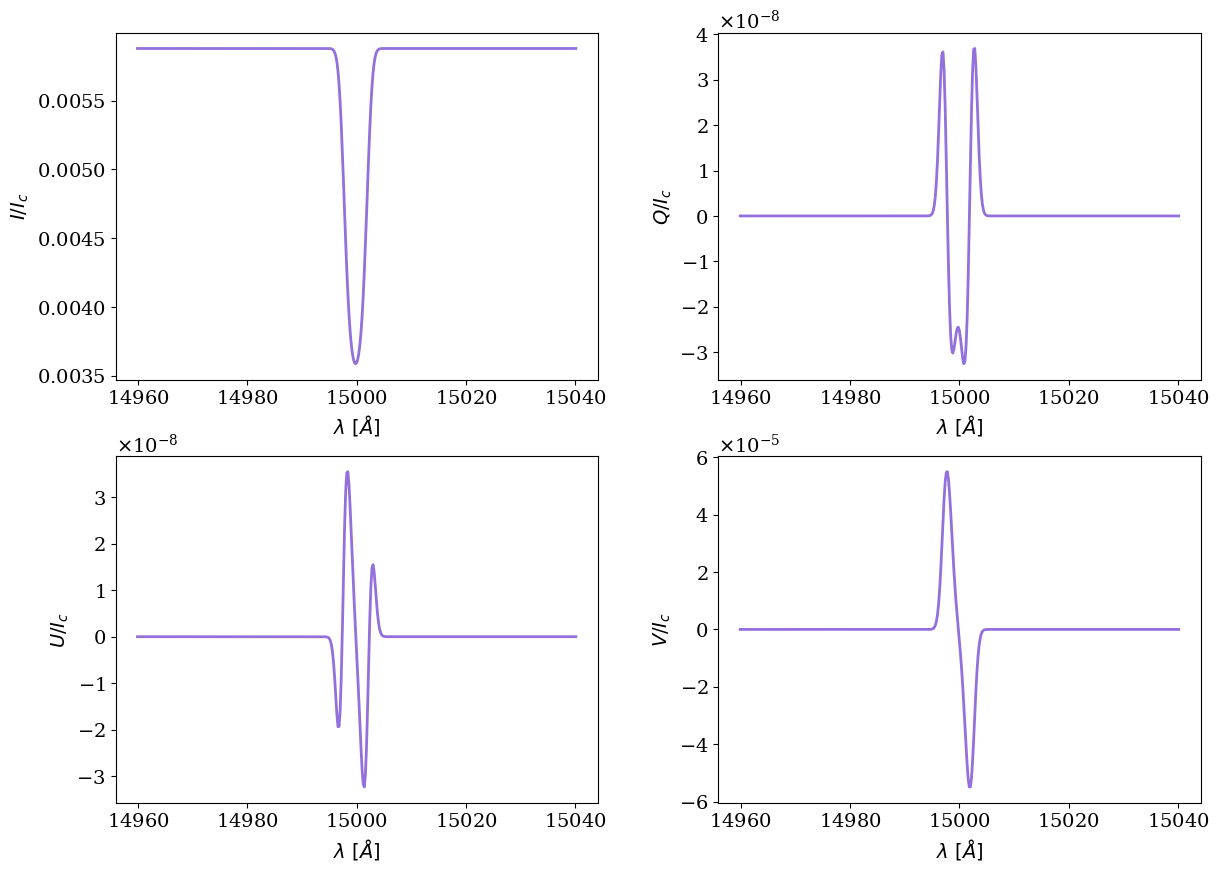

In [31]:
y = np.stack([I_mancha, Q_obs_mancha, U_obs_mancha, V_obs_mancha], axis=1)

#Plot de parámetros de Stokes de la mancha
xlabels = [r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$', r'$\lambda \ [\AA]$']
ylabels = [r'$I/I_c$', r'$Q/I_c$', r'$U/I_c$', r'$V/I_c$']

plot(nrows=2, ncols=2, x=wave, y=y[21, :, :], fig=(14, 10), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels,name='Stokes_mancha');

In [32]:
#Animación de lps parámetros de Stokes de la mancha
anima(dt_show=1, nt=nt, x=wave, y=y, ylim=(1.1, 1.05), off=(-0.001, 0.001), xlabels=xlabels, ylabels=ylabels, \
               title='Evolución de los parámetros de Stokes de la mancha', name = 'Stokes_mancha')

In [33]:
#Mostrar animación
mp4 = open('Stokes_mancha.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 height=650 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [34]:
#Arrays para los parámetros de Stokes de la mancha en la cara visible
I_mancha = I_mancha[index]
Q_obs_mancha = Q_obs_mancha[index]
U_obs_mancha = U_obs_mancha[index]
V_obs_mancha = V_obs_mancha[index]

In [35]:
#Derivadas de la intensidad de la mancha respecto a la longitud de onda
dI_dlambda, d2I_dlambda2 = derivadas(I_mancha, lambda_mancha)

In [36]:
#Factor de Landé efectivo
g_eff = 1

#Constante
C = 4.67 * 10**(-13) #[AA^(-1) G^(-1)]

In [37]:
#Azimuth en el plano del cielo
phi = phi_cal(Q_obs_mancha, U_obs_mancha, d2I_dlambda2) #[rad]

#Componente perpendicular del campo magnético
B_perp = B_perp_cal(Q_obs_mancha, U_obs_mancha, d2I_dlambda2, C, g_eff, lambda_0, phi) #[G]

#Componente paralela del campo magnético
B_parallel = B_parallel_cal(V_obs_mancha, dI_dlambda, C, g_eff, lambda_0) #[G]

#Módulo e inclinación del campo magnético
B, theta = campo(B_perp, B_parallel) #[G], [rad]

In [38]:
#Array de tiempos en la cara visible
t = t[index]

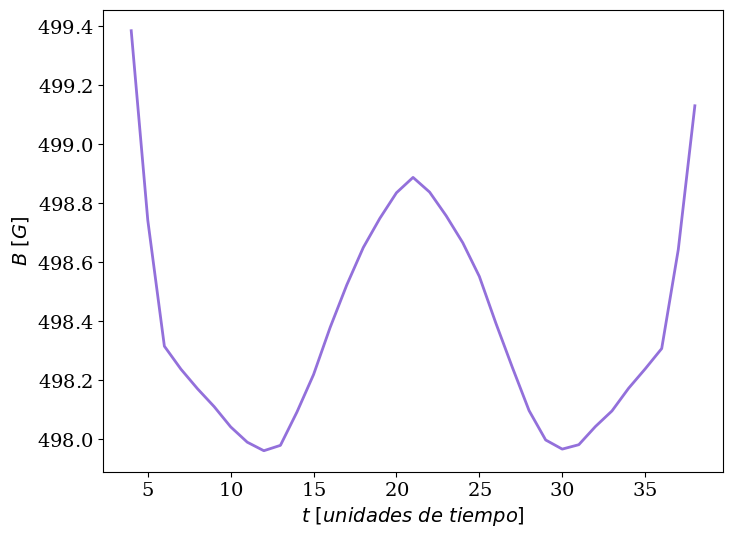

In [39]:
#Plot del campo magnético de la mancha en función del tiempo
xlabel = r'$t \ [unidades \ de \ tiempo]$'
ylabel = r'$B \ [G]$'

plot(nrows=1, ncols=1, x=t, y=B, fig=(8, 6), wspace=0.25, mrk='-', xlabels=xlabel, ylabels=ylabel, name='Btotal')

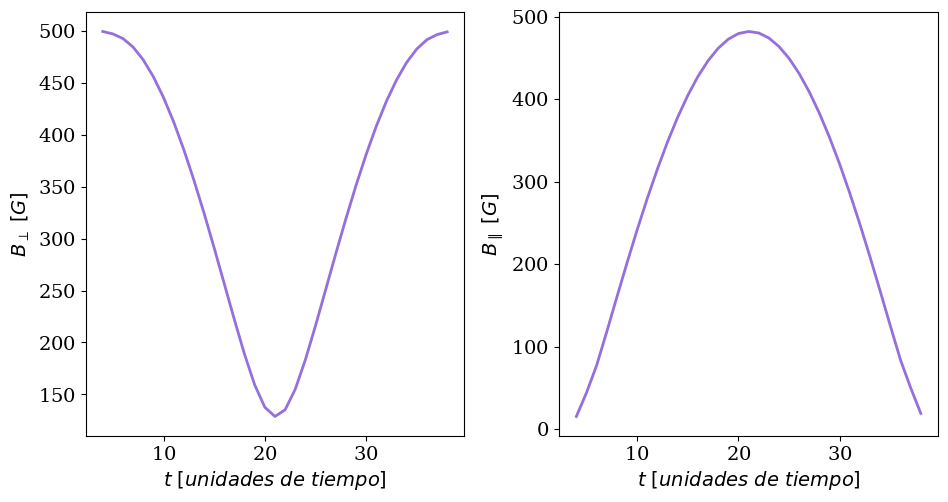

In [40]:
#Plot de las componentes del campo magnético de la mancha en función del tiempo
xlabels = [r'$t \ [unidades \ de \ tiempo]$', r'$t \ [unidades \ de \ tiempo]$']
ylabels = [r'$B_{\perp} \ [G]$', r'$B_{\parallel} \ [G]$']

plot(nrows=1, ncols=2, x=t, y=[B_perp, B_parallel], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='Bcomp');

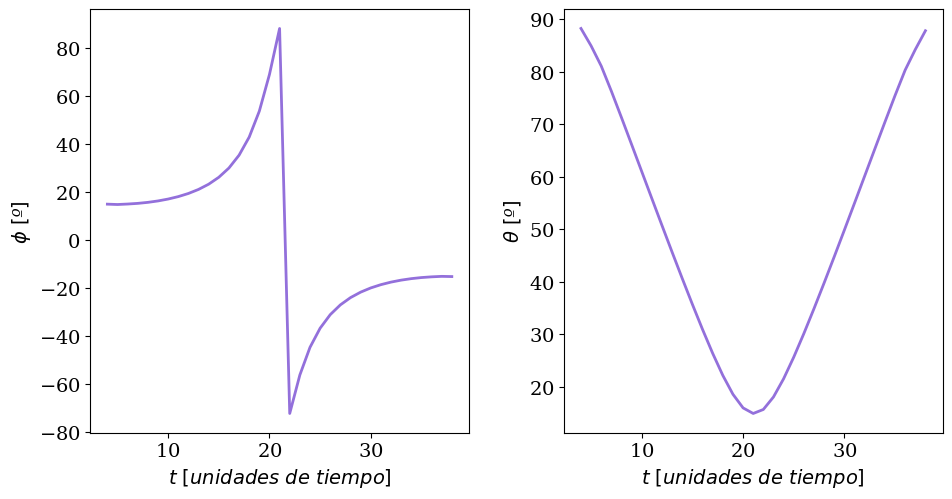

In [41]:
#Plot del azimuth e inclinación del campo magnético en función del tiempo
ylabels = [r'$\phi \ [º]$', r'$\theta \ [º]$']

plot(nrows=1, ncols=2, x=t, y=[phi*180/np.pi, theta*180/np.pi], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='angulos');

- Seeing constante

In [42]:
#Intensidad del continuo a t = 0
Ic_s = Stokes[0, 0, 0]

In [43]:
#Función para normalizar al continuo los parámetros de Stokes de la mancha
def normalizar(Ic, I, Q, U, V):
  if np.isscalar(Ic):
        Ic = Ic * np.ones_like(I)
  else:
        Ic = np.expand_dims(Ic, axis=1)

  I_norm = I/Ic
  Q_norm = Q/Ic
  U_norm = U/Ic
  V_norm = V/Ic

  return I_norm, Q_norm, U_norm, V_norm

In [44]:
#Parámetros de Stokes de la mancha normalizados
I_norm_s, Q_norm_s, U_norm_s, V_norm_s = normalizar(Ic_s, I_mancha, Q_obs_mancha, U_obs_mancha, V_obs_mancha)

In [45]:
#Derivadas de la intensidad de la mancha normalizada respecto a la longitud de onda
dI_dlambda_norm_s, d2I_dlambda2_norm_s =  derivadas(I_norm_s, lambda_mancha)

In [46]:
#Azimuth en el plano del cielo
phi_norm_s = phi_cal(Q_norm_s, U_norm_s, d2I_dlambda2_norm_s) #[rad]

#Componente perpendicular del campo magnético
B_perp_norm_s = B_perp_cal(Q_norm_s, U_norm_s, d2I_dlambda2_norm_s, C, g_eff, lambda_0, phi_norm_s) #[G]

#Componente paralela del campo magnético
B_parallel_norm_s = B_parallel_cal(V_norm_s, dI_dlambda_norm_s, C, g_eff, lambda_0) #[G]

#Módulo e inclinación del campo magnético
B_norm_s, theta_norm_s = campo(B_perp_norm_s, B_parallel_norm_s) #[G], [rad]

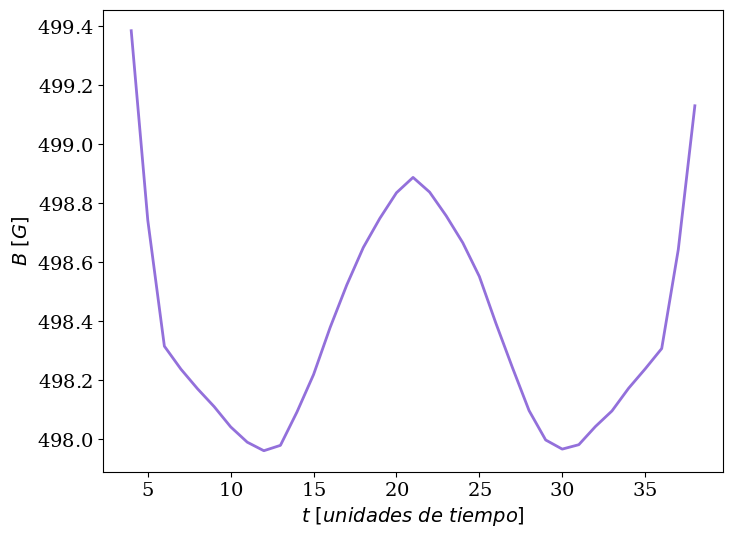

In [47]:
#Plot del campo magnético de la mancha en función del tiempo con seeing estable
xlabel = r'$t \ [unidades \ de \ tiempo]$'
ylabel = r'$B \ [G]$'

plot(nrows=1, ncols=1, x=t, y=B_norm_s, fig=(8, 6), wspace=0.25, mrk='-', xlabels=xlabel, ylabels=ylabel, name='Btotal_s')

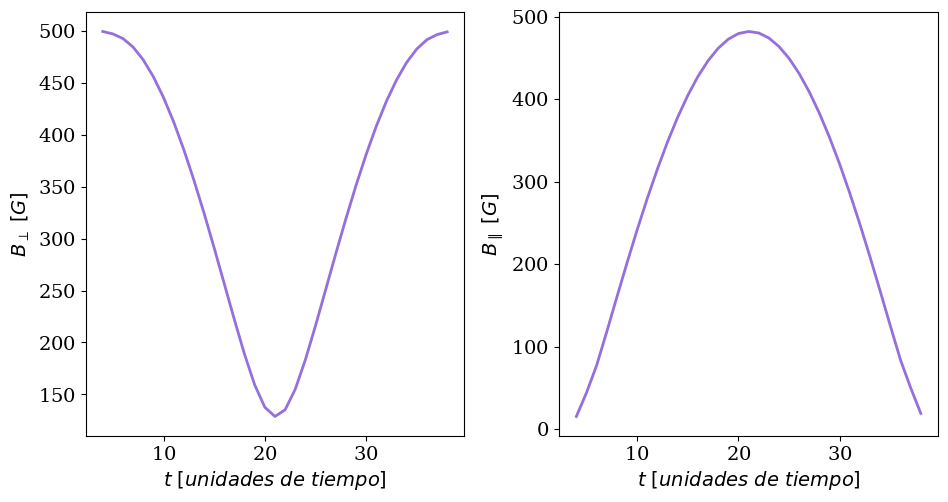

In [48]:
#Plot de las componentes del campo magnético de la mancha en función del tiempo con seeing estable
xlabels = [r'$t \ [unidades \ de \ tiempo]$', r'$t \ [unidades \ de \ tiempo]$']
ylabels = [r'$B_{\perp} \ [G]$', r'$B_{\parallel} \ [G]$']

plot(nrows=1, ncols=2, x=t, y=[B_perp_norm_s, B_parallel_norm_s], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='Bcomp_s');

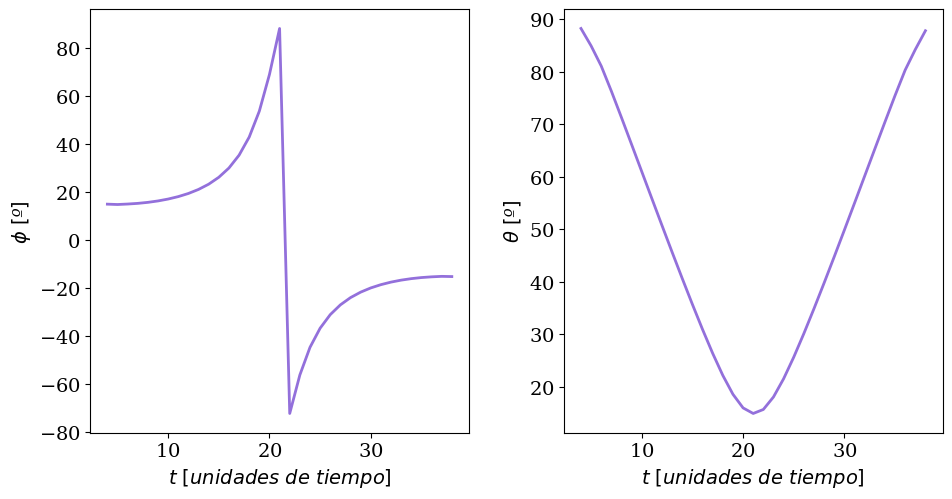

In [49]:
#Plot del azimuth e inclinación del campo magnético en función del tiempo con seeing estable
ylabels = [r'$\phi \ [º]$', r'$\theta \ [º]$']

plot(nrows=1, ncols=2, x=t, y=[phi_norm_s*180/np.pi, theta_norm_s*180/np.pi], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='angulos_s');

- Seeing no constante

In [50]:
#Intensidad del continuo en el tiempo
Ic_v = Stokes[:, 0, 0][index]

In [51]:
#Parámetros de Stokes de la mancha normalizados para seeing variable
I_norm_v, Q_norm_v, U_norm_v, V_norm_v = normalizar(Ic_v, I_mancha, Q_obs_mancha, U_obs_mancha, V_obs_mancha)

In [52]:
#Derivadas de la intensidad de la mancha normalizada respecto a la longitud de onda
dI_dlambda_norm_v, d2I_dlambda2_norm_v = derivadas(I_norm_v, lambda_mancha)

In [53]:
#Azimuth en el plano del cielo
phi_norm_v = phi_cal(Q_norm_v, U_norm_v, d2I_dlambda2_norm_v) #[rad]

#Componente perpendicular del campo magnético
B_perp_norm_v = B_perp_cal(Q_norm_v, U_norm_v, d2I_dlambda2_norm_v, C, g_eff, lambda_0, phi_norm_v) #[G]

#Componente paralela del campo magnético
B_parallel_norm_v = B_parallel_cal(V_norm_v, dI_dlambda_norm_v, C, g_eff, lambda_0) #[G]

#Módulo e inclinación del campo magnético
B_norm_v, theta_norm_v = campo(B_perp_norm_v, B_parallel_norm_v) #[G], [rad]

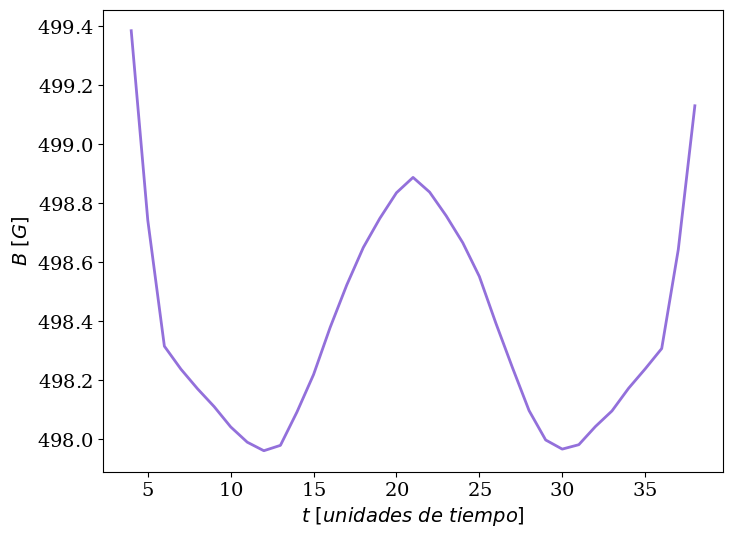

In [54]:
#Plot del campo magnético de la mancha en función del tiempo
xlabel = r'$t \ [unidades \ de \ tiempo]$'
ylabel = r'$B \ [G]$'

plot(nrows=1, ncols=1, x=t, y=B_norm_v, fig=(8, 6), wspace=0.25, mrk='-', xlabels=xlabel, ylabels=ylabel, name='Btotal_v')

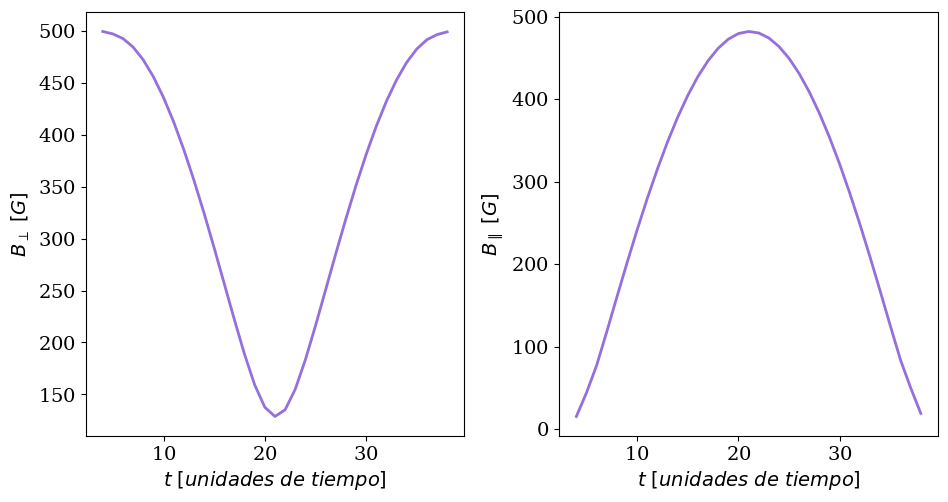

In [55]:
#Plot de las componentes del campo magnético de la mancha en función del tiempo con seeing variable
xlabels = [r'$t \ [unidades \ de \ tiempo]$', r'$t \ [unidades \ de \ tiempo]$']
ylabels = [r'$B_{\perp} \ [G]$', r'$B_{\parallel} \ [G]$']

plot(nrows=1, ncols=2, x=t, y=[B_perp_norm_v, B_parallel_norm_v], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='Bcomp_v');

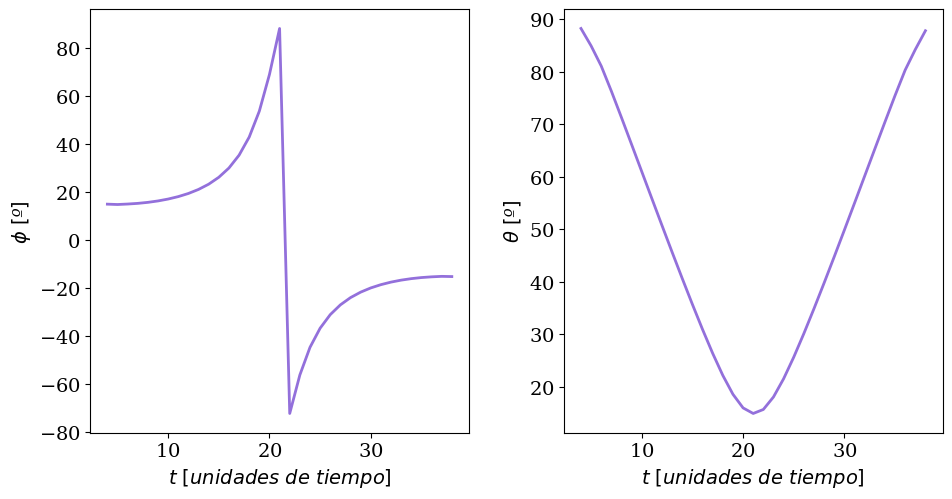

In [56]:
#Plot del azimuth e inclinación del campo magnético en función del tiempo con seeing variable
ylabels = [r'$\phi \ [º]$', r'$\theta \ [º]$']

plot(nrows=1, ncols=2, x=t, y=[phi_norm_v*180/np.pi, theta_norm_v*180/np.pi], fig=(11, 5.5), wspace=0.25, mrk='-', xlabels=xlabels, ylabels=ylabels, name='angulos_v');